### 分析一下数据之间的相关性, 并用曲线拟合 QP - {R,D} 关系

#### 1. 直观绘制一下曲线 (qp - {R,D})

In [17]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 12,
    'text.usetex': False,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    'savefig.bbox': 'tight',
})

sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

In [3]:
import pandas as pd
import numpy as np

size_map = {
    "2160P": "3840x2160",
    "1080P": "1920x1080",
    "720P": "1280x720",
    "540P": "960x540",
    "360P": "640x360",
}
fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(table_dir, exist_ok=True)

In [55]:
# 只编码了 [22, 52, 5] 这七个 QP 点，需要插值得到更多的点
from tqdm import tqdm
from scipy.interpolate import make_interp_spline, interp1d

def interpolate(
        df,
        x_col="qp",
        y_cols=["bitrate", "psnr", "ssim", "vmaf"],
        group_cols=["seqName", "sceneId", "preset", "size"],
        num_points=20,
        use_interp1d=True
):
    interp_df = pd.DataFrame()
    for name, group in tqdm(df.groupby(group_cols)):
        group = group.sort_values(by=x_col)
        interp_group = {x_col: np.linspace(group[x_col].min(), group[x_col].max(), num_points)}

        for y_col in y_cols:
            if use_interp1d:
                interp_func = interp1d(group[x_col], group[y_col], kind='linear', fill_value="extrapolate")
            else:
                interp_func = make_interp_spline(group[x_col], group[y_col], k=3)
                
            interp_group[y_col] = interp_func(interp_group[x_col])  # interpolated y values

        interp_group_df = pd.DataFrame(interp_group)

        for col, value in zip(group_cols, name):
            interp_group_df[col] = value

        # combine interpolated data
        interp_df = pd.concat([interp_df, interp_group_df], ignore_index=True)

    return interp_df

In [3]:
enc_df = pd.read_csv(f"{table_dir}/encInfo.csv")
enc_df = enc_df[["seqName", "sceneId", "preset", "size", "qp", "bitrate", "psnr", "ssim", "vmaf"]]
display(enc_df)

,seqName,sceneId,preset,size,qp,bitrate,psnr,ssim,vmaf
0,Lecture-1033,0,faster,360P,32,57.8571,47.754628,0.997213,95.285921
1,Lecture-1033,2,faster,360P,27,190.5078,49.755053,0.995836,95.477799
2,Lecture-1033,1,faster,360P,42,39.2434,42.998857,0.988553,89.363645
3,Lecture-1033,0,slower,360P,42,27.5214,45.618843,0.996147,92.773328
4,Lecture-1033,1,medium,360P,47,25.6114,41.168286,0.985997,85.511415
...,...,...,...,...,...,...,...,...,...
25019,Lecture-07e0,1,slower,1080P,32,546.9027,44.441940,0.994804,96.029980
25020,Lecture-07e0,1,slower,1080P,37,356.4824,41.881493,0.992692,93.635918
25021,Lecture-07e0,1,faster,1080P,47,174.2794,34.529403,0.970901,74.917759
25022,Lecture-07e0,1,faster,1080P,52,107.3409,30.605672,0.946040,56.786558


In [69]:
y_cols = ["bitrate", "psnr", "ssim", "vmaf"]
enc_df = interpolate(enc_df, "qp", y_cols, group_cols=["seqName", "sceneId", "preset", "size"], num_points=11, use_interp1d=True)

for col in y_cols:
    enc_df[f"log2{col}"] = np.log2(enc_df[col])

fps = 30.0
enc_df["bpp"] = enc_df.apply(lambda x: x["bitrate"] * 1000.0 / (fps * np.prod(list(map(float, size_map[x["size"]].split("x"))))), axis=1)
display(enc_df)

enc_df.to_csv(f"{table_dir}/interp_encInfo.csv", index=False)

100%|██████████| 3576/3576 [01:44<00:00, 34.12it/s]


,qp,bitrate,psnr,ssim,vmaf,seqName,sceneId,preset,size,log2bitrate,log2psnr,log2ssim,log2vmaf,bpp
0,22.0,2976.80360,50.785758,0.996462,97.709019,Lecture-003a,0,faster,1080P,11.539548,5.666352,-0.005114,6.610420,0.047852
1,25.0,2106.48362,48.993000,0.995122,96.800210,Lecture-003a,0,faster,1080P,11.040621,5.614504,-0.007055,6.596938,0.033862
2,28.0,1379.33890,47.221136,0.993519,95.529304,Lecture-003a,0,faster,1080P,10.429761,5.561361,-0.009381,6.577871,0.022173
3,31.0,938.54470,45.491061,0.991390,93.534205,Lecture-003a,0,faster,1080P,9.874282,5.507511,-0.012476,6.547422,0.015087
4,34.0,665.37818,43.975167,0.988909,91.180145,Lecture-003a,0,faster,1080P,9.378031,5.458617,-0.016091,6.510648,0.010696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39331,40.0,319.79770,41.497545,0.982836,90.904011,Lecture-7f7e,4,slower,720P,8.321016,5.374954,-0.024977,6.506272,0.011567
39332,43.0,235.57192,39.730736,0.976251,88.252747,Lecture-7f7e,4,slower,720P,7.880024,5.312184,-0.034676,6.463569,0.008520
39333,46.0,179.72518,37.967165,0.967104,84.498439,Lecture-7f7e,4,slower,720P,7.489649,5.246680,-0.048257,6.400853,0.006500
39334,49.0,137.39076,36.118823,0.953658,78.622216,Lecture-7f7e,4,slower,720P,7.102141,5.174679,-0.068456,6.296865,0.004969


In [10]:
enc_df = pd.read_csv(f"{table_dir}/encInfo.csv")
seqNames = enc_df["seqName"].unique()
display(enc_df)

,seqName,sceneId,qp,preset,size,nframes,bitrate,psnr,ssim,vmaf,log2psnr,log2ssim,log2bitrate,log2vmaf,bpp
0,Lecture-1033,0,32,faster,360P,281,57.8571,47.754628,0.997213,95.285921,5.577569,-0.004026,5.854422,6.574191,0.008371
1,Lecture-1033,2,27,faster,360P,285,190.5078,49.755053,0.995836,95.477799,5.636771,-0.006020,7.573706,6.577093,0.027562
2,Lecture-1033,1,42,faster,360P,35,39.2434,42.998857,0.988553,89.363645,5.426226,-0.016610,5.294378,6.481616,0.005678
3,Lecture-1033,0,42,slower,360P,281,27.5214,45.618843,0.996147,92.773328,5.511558,-0.005570,4.782482,6.535638,0.003982
4,Lecture-1033,1,47,medium,360P,35,25.6114,41.168286,0.985997,85.511415,5.363461,-0.020345,4.678714,6.418045,0.003705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25019,Lecture-07e0,1,32,slower,1080P,67,546.9027,44.441940,0.994804,96.029980,5.473850,-0.007515,9.095140,6.585413,0.008792
25020,Lecture-07e0,1,37,slower,1080P,67,356.4824,41.881493,0.992692,93.635918,5.388241,-0.010582,8.477687,6.548990,0.005730
25021,Lecture-07e0,1,47,faster,1080P,67,174.2794,34.529403,0.970901,74.917759,5.109753,-0.042604,7.445258,6.227236,0.002802
25022,Lecture-07e0,1,52,faster,1080P,67,107.3409,30.605672,0.946040,56.786558,4.935727,-0.080027,6.746056,5.827478,0.001726


##### 1.1 qp - bitrate : 幂函数

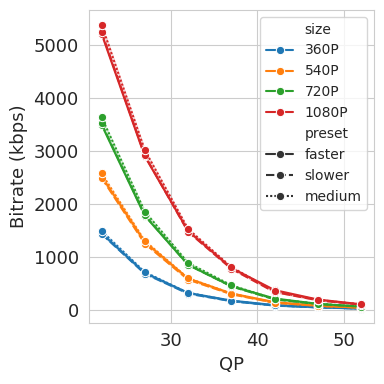

In [18]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="bitrate", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("Bitrate (kbps)")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-bitrate.pdf", format="pdf")

In [ ]:
plt.figure(figsize=(5,4))
os.makedirs(f"{fig_dir}/corrs/bitrate", exist_ok=True)

for seqName in tqdm(seqNames):
    sns.lineplot(data=enc_df[enc_df["seqName"] == seqName], x="qp", y="bitrate", hue="size", style="preset", marker=".", errorbar=("ci", 0))
    
    plt.xlabel("QP")
    plt.ylabel("Bitrate (kbps)")
    plt.legend(loc="upper right")
    
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/corrs/bitrate/qp-bitrate-{seqName}.pdf", format="pdf")
    plt.close()

##### 1.2 qp - log2bitrate : 线性函数

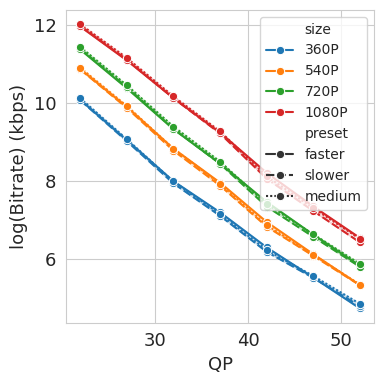

In [20]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="log2bitrate", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("log(Bitrate) (kbps)")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-log2bitrate.pdf", format="pdf")

In [ ]:
plt.figure(figsize=(5,4))

seqNames = enc_df["seqName"].unique()
for seqName in seqNames:
    sns.lineplot(data=enc_df[enc_df["seqName"] == seqName], x="qp", y="log2bitrate", hue="size", style="preset", marker=".", errorbar=("ci", 0))
    
    plt.xlabel("QP")
    plt.ylabel("log(Bitrate) (kbps)")
    plt.legend(loc="upper right")
    
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/corrs/qp-log2bitrate-{seqName}.pdf", format="pdf")
    plt.close()

##### 2.1 qp - psnr : 线性函数

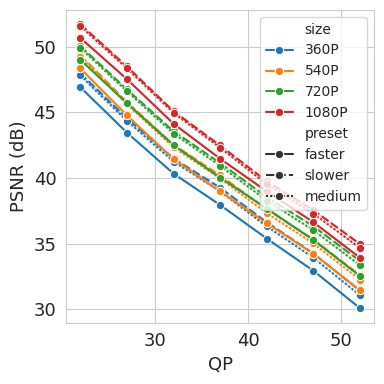

In [21]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="psnr", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("PSNR (dB)")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-psnr.pdf", format="pdf")

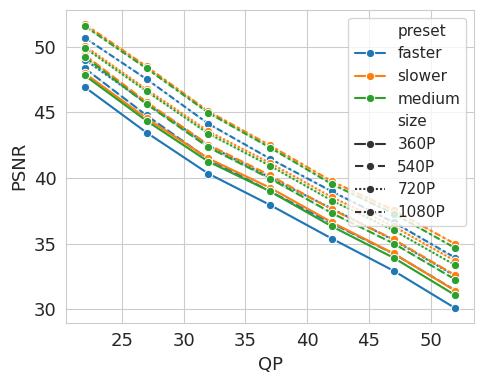

In [29]:
plt.figure(figsize=(5,4))
seqNames = enc_df["seqName"].unique()
for seqName in seqNames:
    sns.lineplot(data=enc_df[enc_df["seqName"] == seqName], x="qp", y="psnr", hue="size", style="preset", marker=".", errorbar=("ci", 0))

    plt.xlabel("QP")
    plt.ylabel("PSNR (dB)")
    plt.legend(loc="upper right")
    
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/corrs/qp-psnr-{seqName}.png", dpi=400)
    plt.close()

##### 2.2 qp - log2psnr: 线性函数

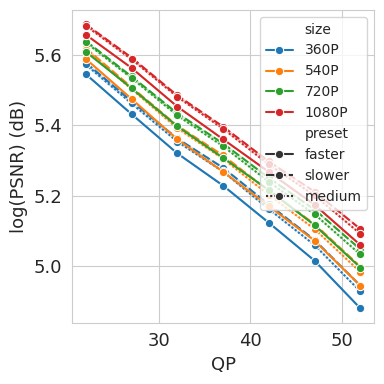

In [22]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="log2psnr", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("log(PSNR) (dB)")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-log2psnr.pdf", format="pdf")

##### 3.1 qp - ssim : 二次函数

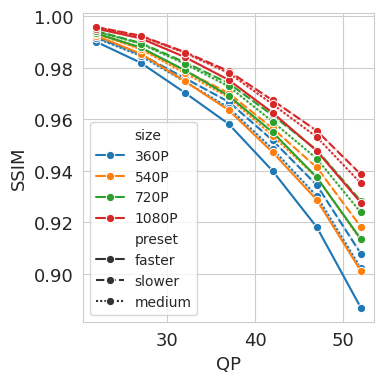

In [23]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="ssim", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("SSIM")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-ssim.pdf", format="pdf")

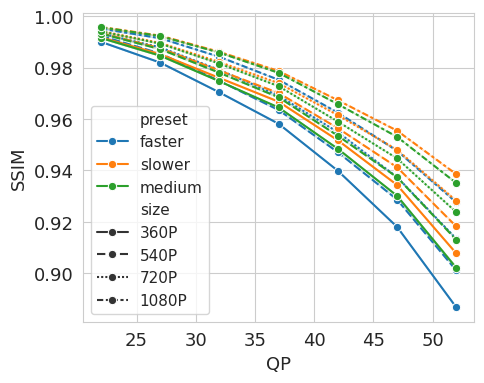

In [30]:
plt.figure(figsize=(4,4))
seqNames = enc_df["seqName"].unique()
for seqName in seqNames:
    sns.lineplot(data=enc_df[enc_df["seqName"] == seqName], x="qp", y="ssim", hue="size", style="preset", marker=".", errorbar=("ci", 0))

    plt.xlabel("QP")
    plt.ylabel("SSIM")
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/corrs/qp-ssim-{seqName}.png", dpi=400)
    plt.close()

##### 3.2 qp - log2ssim: 二次函数

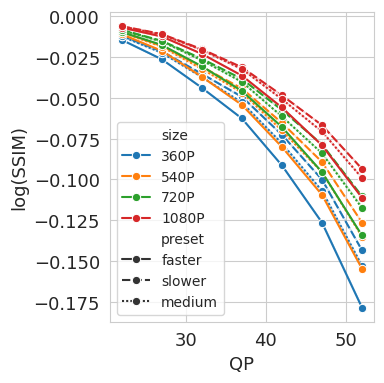

In [24]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="log2ssim", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("log(SSIM)")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-log2ssim.pdf", format="pdf")

##### 4.1 qp - vmaf: 二次函数

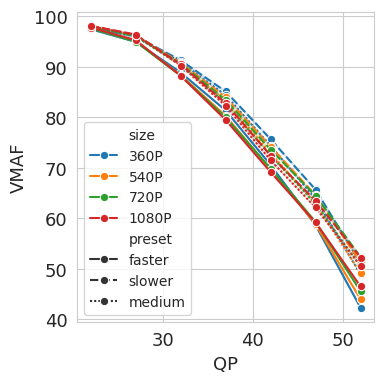

In [25]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="vmaf", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("VMAF")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-vmaf.pdf", format="pdf")

##### 4.2 qp - log2vmaf: 二次函数

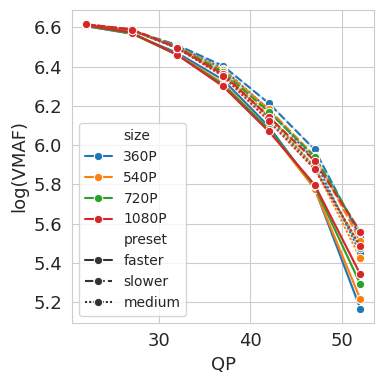

In [26]:
plt.figure(figsize=(4,4))
sns.lineplot(data=enc_df, x="qp", y="log2vmaf", hue="size", style="preset", marker="o", errorbar=("ci", 0))

plt.xlabel("QP")
plt.ylabel("log(VMAF)")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig(f"{fig_dir}/corrs/qp-log2vmaf.pdf", format="pdf")

#### 2. 计算一下相关系数

In [9]:
# 1. 同一指标, 不同 preset 之间的相关性
import pandas as pd
targets = ["log2bitrate", "log2psnr", "log2ssim", "log2vmaf", "bitrate", "psnr", "ssim", "vmaf"]

enc_df = pd.read_csv(f"{table_dir}/interp_encInfo.csv")
display(enc_df)

src_df = enc_df[(enc_df["preset"] == "faster") & (enc_df["size"] == "540P")].reset_index(drop=True)

rows = []
for preset in enc_df["preset"].unique():
    for size in enc_df["size"].unique():
        if preset == "faster" and size == "540P":
            continue
        
        dst_df = enc_df[(enc_df["preset"] == preset) & (enc_df["size"] == size)].reset_index(drop=True)
        for target in targets:
            corr = src_df[target].corr(dst_df[target])
            rows.append([preset, size, target, corr])

corr_df = pd.DataFrame(rows, columns=["preset", "size", "target", "corr"])
corr_df["preset"] = corr_df["preset"].astype("object")

display(corr_df)        # 直接算的话, 跨 preset 相关性很低

,qp,bitrate,psnr,ssim,vmaf,seqName,sceneId,preset,size,log2bitrate,log2psnr,log2ssim,log2vmaf,bpp
0,22.0,2976.80360,50.785758,0.996462,97.709019,Lecture-003a,0,faster,1080P,11.539548,5.666352,-0.005114,6.610420,0.047852
1,25.0,2106.48362,48.993000,0.995122,96.800210,Lecture-003a,0,faster,1080P,11.040621,5.614504,-0.007055,6.596938,0.033862
2,28.0,1379.33890,47.221136,0.993519,95.529304,Lecture-003a,0,faster,1080P,10.429761,5.561361,-0.009381,6.577871,0.022173
3,31.0,938.54470,45.491061,0.991390,93.534205,Lecture-003a,0,faster,1080P,9.874282,5.507511,-0.012476,6.547422,0.015087
4,34.0,665.37818,43.975167,0.988909,91.180145,Lecture-003a,0,faster,1080P,9.378031,5.458617,-0.016091,6.510648,0.010696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39331,40.0,319.79770,41.497545,0.982836,90.904011,Lecture-7f7e,4,slower,720P,8.321016,5.374954,-0.024977,6.506272,0.011567
39332,43.0,235.57192,39.730736,0.976251,88.252747,Lecture-7f7e,4,slower,720P,7.880024,5.312184,-0.034676,6.463569,0.008520
39333,46.0,179.72518,37.967165,0.967104,84.498439,Lecture-7f7e,4,slower,720P,7.489649,5.246680,-0.048257,6.400853,0.006500
39334,49.0,137.39076,36.118823,0.953658,78.622216,Lecture-7f7e,4,slower,720P,7.102141,5.174679,-0.068456,6.296865,0.004969


,preset,size,target,corr
0,faster,1080P,log2bitrate,0.992792
1,faster,1080P,log2psnr,0.990731
2,faster,1080P,log2ssim,0.963529
3,faster,1080P,log2vmaf,0.946314
4,faster,1080P,bitrate,0.989331
...,...,...,...,...
83,slower,720P,log2vmaf,0.964824
84,slower,720P,bitrate,0.996249
85,slower,720P,psnr,0.995142
86,slower,720P,ssim,0.969250


##### 为每个指标画一下相关性

<Axes: xlabel='target', ylabel='corr'>

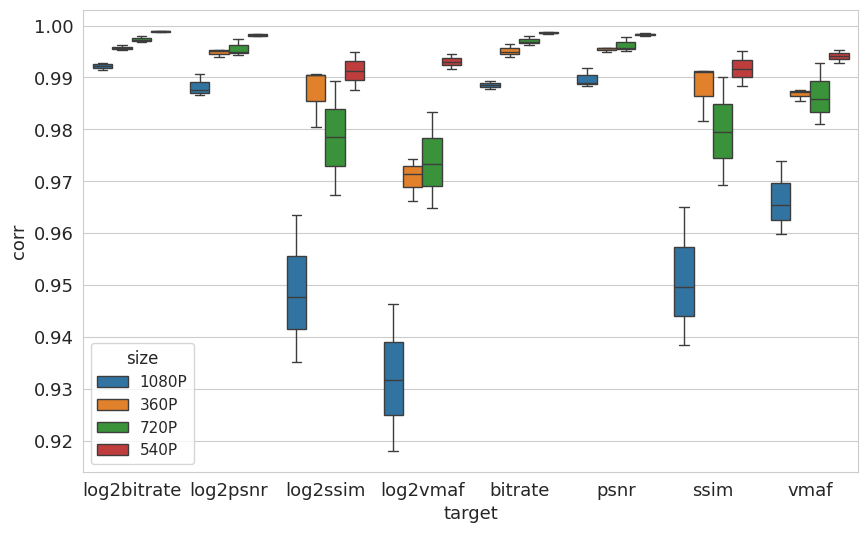

In [11]:
plt.figure(figsize=(10, 6))

# 看线性相关性不科学 - 不同 preset 的 metrics 可能差不多, 但不同 size 的 metrics 很可能差很多
sns.boxplot(data=corr_df, x="target", y="corr", hue="size", flierprops=flierprops)

<Axes: xlabel='target', ylabel='corr'>

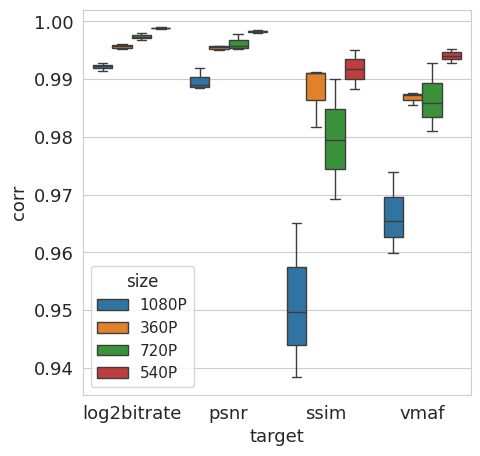

In [14]:
# 只画一下 log2bitrate, psnr, ssim, vmaf
plt.figure(figsize=(5, 5))

sns.boxplot(data=corr_df[corr_df["target"].isin(["log2bitrate", "psnr", "ssim", "vmaf"])], x="target", y="corr", hue="size", flierprops=flierprops)

In [ ]:
# 尝试一下函数拟合 (对每个 preset, 都拟合一条 QP-{R,D} 曲线)
def func_quad3(x, a, b, c):
    return a * ((x - b) ** 2) + c

from fastCAE.utils import func_linear, func_pw2, func_pw3, func_quad2
from tqdm import tqdm
from scipy.optimize import curve_fit
from concurrent.futures import ThreadPoolExecutor

def _process_single(args):
    seqName, sceneId, preset, size, df, funcs, targets = args
    rows = []
    
    x = df["qp"]
    for target in targets:
        y = df[target]
        for func in funcs:
            try:
                popt, pconv = curve_fit(f=func, xdata=x, ydata=y, full_output=False, maxfev=3000)
                pred_value = func(x, *popt)
                abs_error  = pred_value - y
                r2 = 1.0 - (np.var(abs_error) / np.var(y))
                row = [seqName, sceneId, preset, size, tuple(popt), func.__name__.replace("func_", "").replace("pw2", "power").replace("quad", "quadratic"), target, r2] + y.tolist()[:5]
                rows.append(row)
                    
            except Exception as e:
                print(f"{e} (seqName={seqName}, sceneId={sceneId}, size={size}, func={func.__name__})")
                continue
                
    return rows

funcs = [func_linear, func_pw2, func_pw3, func_quad2, func_quad3]
targets = ["log2bitrate", "log2psnr", "log2ssim", "log2vmaf", "bitrate", "psnr", "ssim", "vmaf"]

rows  = []
tasks = []
for (seqName, sceneId, preset, size), group in enc_df.groupby(["seqName", "sceneId", "preset", "size"]):
    group = group.reset_index(drop=True)
    tasks.append((seqName, sceneId, preset, size, group, funcs, targets))
    
with ThreadPoolExecutor(max_workers=24) as executor:
    results = list(tqdm(executor.map(_process_single, tasks), total=len(tasks)))
    
for result in results:
    rows.extend(result) 
    
cols = ["seqName", "sceneId", "preset", "size", "popt", "func", "target", "r2"] + [f"y{i}" for i in range(5)]
r2_scores_df = pd.DataFrame(rows, columns=cols)
display(r2_scores_df)

In [5]:
def rm_outliers(df, cols, threshold=1.5, lower_only=True):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        if lower_only:
            df = df[df[col] >= lower_bound]
        else:
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

In [6]:
r2_scores_df = pd.read_csv(f"{table_dir}/corrs.csv")
display(r2_scores_df)

r2_scores_df = rm_outliers(r2_scores_df, cols=["r2"])
display(r2_scores_df.describe())

r2_scores_df.isnull().values.any()  # NaN detection

,seqName,sceneId,preset,size,popt,func,target,r2,y0,y1,y2,y3,y4
0,Lecture-003a,0,faster,1080P,"(-0.16326344151660152, 15.030353642916932)",linear,log2bitrate,0.997989,11.539548,11.040621,10.429761,9.874282,9.378031
1,Lecture-003a,0,faster,1080P,"(78.77031354394663, -0.6107135290783908)",power,log2bitrate,0.975265,11.539548,11.040621,10.429761,9.874282,9.378031
2,Lecture-003a,0,faster,1080P,"(-0.002169759347481953, 12.155285194958516)",quadratic2,log2bitrate,0.977612,11.539548,11.040621,10.429761,9.874282,9.378031
3,Lecture-003a,0,faster,1080P,"(0.000677711444214859, 157.45203254325867, -0....",quadratic3,log2bitrate,0.999196,11.539548,11.040621,10.429761,9.874282,9.378031
4,Lecture-003a,0,faster,1080P,"(-0.01779429393364662, 6.063721170426781)",linear,log2psnr,0.995075,5.666352,5.614504,5.561361,5.507511,5.458617
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109019,Lecture-7f7e,4,slower,720P,"(-8.894869948597122e-05, 26.91355341848198, 0....",quadratic3,ssim,0.988736,0.997462,0.996316,0.994895,0.992925,0.990618
109020,Lecture-7f7e,4,slower,720P,"(-0.75350137498404, 117.46400047318546)",linear,vmaf,0.834786,96.924079,96.477309,95.903620,95.076089,94.081648
109021,Lecture-7f7e,4,slower,720P,"(232.28017811873178, -0.2671392803476199)",power,vmaf,0.719152,96.924079,96.477309,95.903620,95.076089,94.081648
109022,Lecture-7f7e,4,slower,720P,"(-0.010538010925847274, 104.95940753659809)",quadratic2,vmaf,0.905566,96.924079,96.477309,95.903620,95.076089,94.081648


,sceneId,r2,y0,y1,y2,y3,y4
count,97063.000000,97063.000000,97063.000000,97063.000000,97063.000000,97063.000000,97063.000000
mean,8.035997,0.965222,186.598630,140.889262,101.324490,74.097114,56.234429
std,9.102670,0.044006,963.299848,705.372625,481.626179,323.642944,220.328175
min,0.000000,0.814624,-0.063565,-0.101094,-0.148539,-0.216218,-0.291305
25%,1.000000,0.953178,0.997551,0.996629,0.995563,0.994227,0.992785
50%,4.000000,0.984881,6.622483,6.602190,6.576210,6.524095,6.475704
75%,12.000000,0.995542,48.899875,46.841647,44.779313,42.762875,40.981939
max,39.000000,0.999971,19820.565000,14558.040000,10589.821500,7346.406000,5153.326500


False

In [17]:
r2_scores_df["func"].unique()

array(['linear', 'power', 'quadratic2', 'quadratic3'], dtype=object)

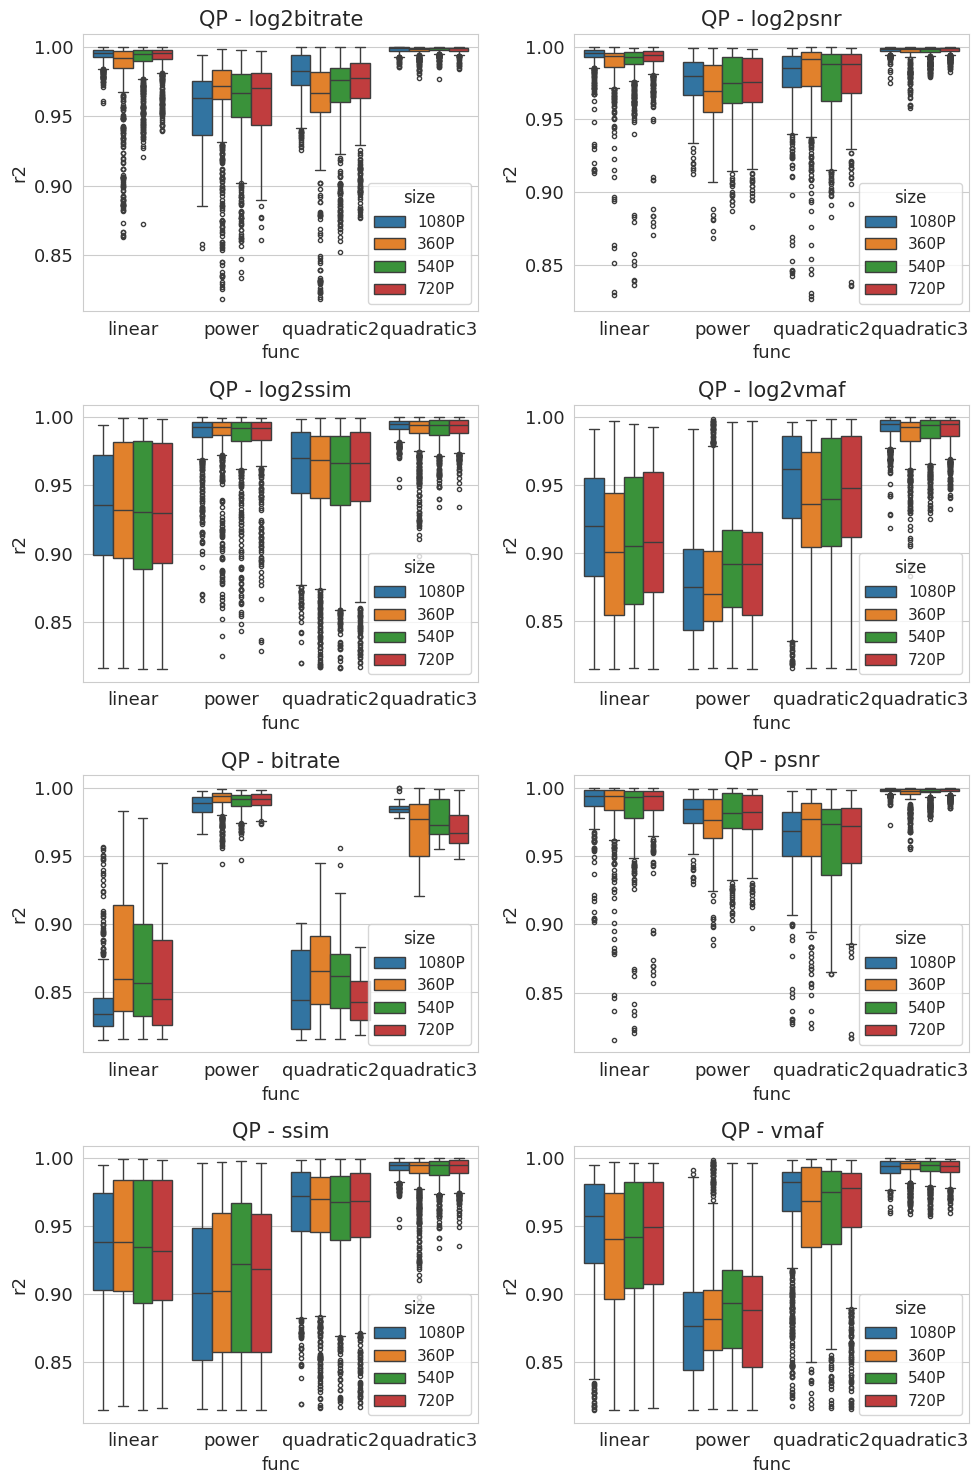

In [18]:
# 画一下不同函数拟合的结果
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()

for i, target in enumerate(["log2bitrate", "log2psnr", "log2ssim", "log2vmaf", "bitrate", "psnr", "ssim", "vmaf"]):
    ax = axes[i]
    sns.boxplot(data=r2_scores_df[r2_scores_df["target"] == target], x="func", y="r2", hue="size", ax=ax, order=["linear", "power", "quadratic2", "quadratic3"], flierprops=flierprops)
    ax.set_title(f"QP - {target}")

plt.tight_layout()
# plt.savefig(f"{fig_dir}/corrs.png", dpi=400)

#### 各项指标预测最适合的函数

| 指标   | 是否需要取 log | 最适合的预测函数   |
| ------ | --------------- | ------------------ |
| bitrate | 是             | 二次函数           |
| psnr   | 都行            | 二次函数           |
| ssim   | 是             | 幂函数 / 二次函数  |
| vmaf   | 否             | 二次函数           |

#### 所以直接都用二次函数好了, 只有 vmaf 不取 log

In [19]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 12,
    'text.usetex': False,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    'figure.figsize': (6.4, 4.8),
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})

sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=3, linestyle='none')

In [20]:
r2_scores_df = pd.read_csv(f"{table_dir}/corrs.csv")
r2_scores_df = rm_outliers(r2_scores_df, cols=["r2"])
r2_scores_df["func"] = r2_scores_df["func"].str.replace("func_", "").replace("pw2", "power")

display(r2_scores_df.describe())
print(r2_scores_df["target"].unique())

,sceneId,r2,y0,y1,y2,y3,y4
count,97063.000000,97063.000000,97063.000000,97063.000000,97063.000000,97063.000000,97063.000000
mean,8.035997,0.965222,186.598630,140.889262,101.324490,74.097114,56.234429
std,9.102670,0.044006,963.299848,705.372625,481.626179,323.642944,220.328175
min,0.000000,0.814624,-0.063565,-0.101094,-0.148539,-0.216218,-0.291305
25%,1.000000,0.953178,0.997551,0.996629,0.995563,0.994227,0.992785
50%,4.000000,0.984881,6.622483,6.602190,6.576210,6.524095,6.475704
75%,12.000000,0.995542,48.899875,46.841647,44.779313,42.762875,40.981939
max,39.000000,0.999971,19820.565000,14558.040000,10589.821500,7346.406000,5153.326500


['log2bitrate' 'log2psnr' 'log2ssim' 'log2vmaf' 'bitrate' 'psnr' 'ssim'
 'vmaf']


In [21]:
""" 仔细把这个拟合关系图重新画一遍 """
for target in r2_scores_df["target"].unique():
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=r2_scores_df[r2_scores_df["target"] == target], x="func", y="r2", hue="size", flierprops=flierprops, palette="pastel", order=["linear", "power", "quadratic"])
    
    plt.title(f"Curve Fitting (QP - {target})")
    plt.xlabel("")
    plt.ylabel("R2")
    
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/r2-QP-{target}.pdf", format="pdf")
    plt.close()

In [115]:
""" 分组计算 r2 的均值和方差"""
stats = r2_scores_df.groupby(["target", "func", "size", "preset"])["r2"].agg(["mean", "std"]).reset_index()
display(stats)

stats.to_csv(f"{table_dir}/r2-QP-target.csv", index=False)

,target,func,size,preset,mean,std
0,bitrate,linear,360P,faster,0.862260,0.052649
1,bitrate,linear,360P,medium,0.857466,0.051295
2,bitrate,linear,360P,slower,0.857323,0.052662
3,bitrate,linear,540P,faster,0.853738,0.047636
4,bitrate,linear,540P,medium,0.850551,0.045927
...,...,...,...,...,...,...
211,vmaf,quadratic,540P,medium,0.990760,0.008898
212,vmaf,quadratic,540P,slower,0.990469,0.009188
213,vmaf,quadratic,720P,faster,0.990884,0.008304
214,vmaf,quadratic,720P,medium,0.990406,0.008358


In [9]:
stats = pd.read_csv("/home/zhaoy/encCAE/fastCAE/results/vvenc/tables/r2-QP-target.csv")
display(stats.describe())

,mean,std
count,216.000000,216.000000
mean,0.954072,0.027874
std,0.046361,0.020525
min,0.839313,0.001978
25%,0.911481,0.012015
50%,0.978593,0.019708
75%,0.989448,0.051088
max,0.998070,0.068695
